### Mount Google Drive and Install Packages

In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Install necessary packages
!pip install opencv-python-headless tensorflow tensorflow-addons


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import Libraries and Load Data

The directory is not empty. No extraction needed.


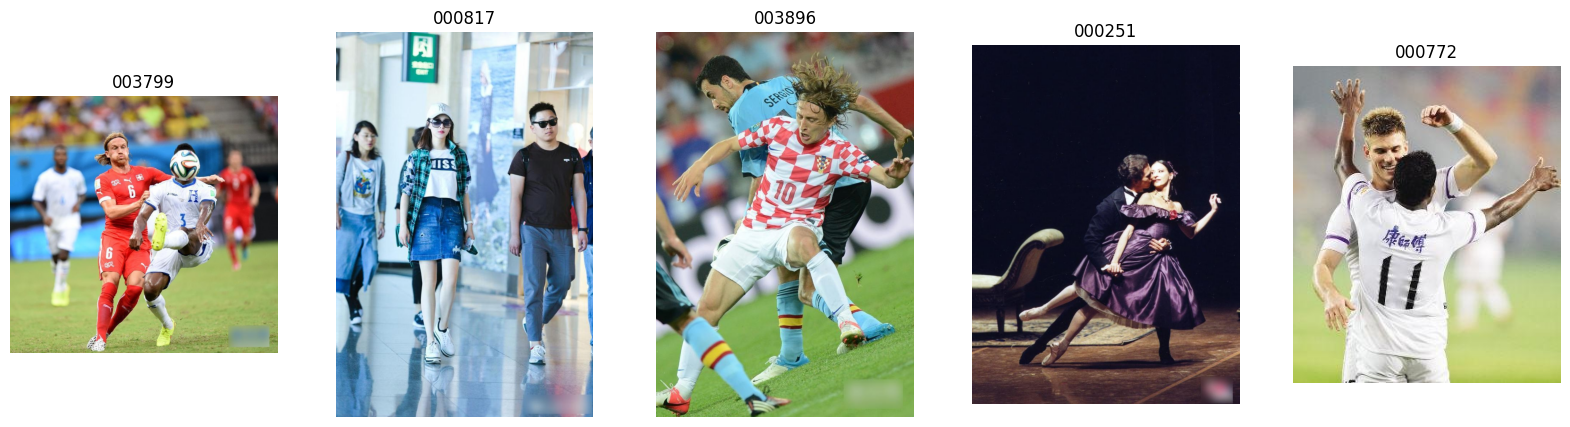

In [8]:
import os
import zipfile
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models

# Root path for the OCHuman shared dataset
root_dir = '/content/gdrive/My Drive/OCHuman'

# Path to the zip file in Google Drive
zip_path = os.path.join(root_dir, 'images.zip')

# Extracted images root path
images_extract_dir = '/content/gdrive/My Drive/'
images_data_root_dir = '/content/gdrive/My Drive/ochuman_images/images'

# Check if the directory exists, if not create it
if not os.path.exists(images_data_root_dir):
    os.makedirs(images_data_root_dir)
    print(f"Created directory: {images_data_root_dir}")

# Check if the directory is empty
if not os.listdir(images_data_root_dir):
    # Extract the images to another directory
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(images_extract_dir, 'ochuman_images'))
else:
    print("The directory is not empty. No extraction needed.")

# Load annotations
ochuman_json = os.path.join(root_dir, 'ochuman.json')

with open(ochuman_json) as f:
    data = json.load(f)

images_data = data['images']

# Display sample images
def display_sample_images(image_folder, images_data, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, entry in enumerate(images_data[:num_samples]):
        image_path = os.path.join(image_folder, entry['file_name'])
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(entry['image_id'])

        # Overlay keypoints if they are available and visible
        if 'keypoints' in entry and 'num_keypoints' in entry and entry['num_keypoints'] > 0:
            keypoints = np.array(entry['keypoints']).reshape(-1, 3)
            visible_points = keypoints[keypoints[:, 2] == 2]
            axes[i].scatter(visible_points[:, 0], visible_points[:, 1], color='red', s=10)

    plt.show()

# Display sample images
display_sample_images(images_data_root_dir, images_data)

# Load training and test annotations
def load_annotations(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

train_annotations_path = os.path.join(root_dir, 'ochuman_coco_format_val_range_0.00_1.00.json')
test_annotations_path = os.path.join(root_dir, 'ochuman_coco_format_test_range_0.00_1.00.json')

train_data = load_annotations(train_annotations_path)
test_data = load_annotations(test_annotations_path)


### Define Dataset Class and Transformations

In [9]:
# Define a dataset class
class HumanPoseDataset(Dataset):
    def __init__(self, annotations, images_data_root_dir, transform=None):
        self.annotations = annotations['annotations']
        self.root_dir = images_data_root_dir
        self.transform = transform
        self.image_info = {image['id']: image for image in annotations['images']}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image_path = os.path.join(self.root_dir, self.image_info[ann['image_id']]['file_name'])
        image = Image.open(image_path).convert('RGB')
        keypoints = torch.tensor(ann['keypoints'], dtype=torch.float32).view(-1, 3)  # reshape and convert to tensor

        if self.transform:
            image = self.transform(image)

        return image, keypoints[:, :2].flatten()

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create dataset objects
train_dataset = HumanPoseDataset(train_data, images_data_root_dir, transform)
test_dataset = HumanPoseDataset(test_data, images_data_root_dir, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [19]:
num_keypoints =  17  # Define the number of keypoints in your dataset here

# Instantiate the model
model = PoseEstimator(num_keypoints)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define Model Architecture and Instantiate Model (RESNET MODEL)

In [21]:
# Define the model architecture
class PoseEstimator(nn.Module):
    def __init__(self, num_keypoints):
        super(PoseEstimator, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, num_keypoints * 2)  # Output layer with 2 keypoints (x, y) for each keypoint

    def forward(self, x):
        return self.resnet(x)


### Define Loss Function and Optimizer, and Training Loop

In [22]:
# Define loss function (Smooth L1 Loss) and optimizer (AdamW)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters())

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    for i, (images, keypoints) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, keypoints)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        if i % 10 == 0:  # Print every 10 batches
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{total_batches}, Batch Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Epoch Loss: {epoch_loss:.4f}')


Epoch 1/5, Batch 1/269, Batch Loss: 290.3448
Epoch 1/5, Batch 11/269, Batch Loss: 322.8417
Epoch 1/5, Batch 21/269, Batch Loss: 317.5563
Epoch 1/5, Batch 31/269, Batch Loss: 282.2062
Epoch 1/5, Batch 41/269, Batch Loss: 285.9678
Epoch 1/5, Batch 51/269, Batch Loss: 287.6403
Epoch 1/5, Batch 61/269, Batch Loss: 277.6202
Epoch 1/5, Batch 71/269, Batch Loss: 319.9531
Epoch 1/5, Batch 81/269, Batch Loss: 291.5125
Epoch 1/5, Batch 91/269, Batch Loss: 254.0085
Epoch 1/5, Batch 101/269, Batch Loss: 254.6838
Epoch 1/5, Batch 111/269, Batch Loss: 252.9044
Epoch 1/5, Batch 121/269, Batch Loss: 235.4118
Epoch 1/5, Batch 131/269, Batch Loss: 197.8554
Epoch 1/5, Batch 141/269, Batch Loss: 210.4180
Epoch 1/5, Batch 151/269, Batch Loss: 214.0782
Epoch 1/5, Batch 161/269, Batch Loss: 189.8463
Epoch 1/5, Batch 171/269, Batch Loss: 224.3378
Epoch 1/5, Batch 181/269, Batch Loss: 222.5120
Epoch 1/5, Batch 191/269, Batch Loss: 164.0627
Epoch 1/5, Batch 201/269, Batch Loss: 169.0640
Epoch 1/5, Batch 211/269

### Define Evaluation Function and Evaluate the Model

In [23]:
# Define evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    count = 0

    for images, keypoints in test_loader:
        outputs = model(images)
        loss = criterion(outputs, keypoints)
        total_loss += loss.item() * images.size(0)
        count += images.size(0)

    average_loss = total_loss / count
    print(f"Mean Squared Error on the test set: {average_loss:.4f}")

# Evaluate the model
evaluate_model(model, test_loader, criterion)


Mean Squared Error on the test set: 129.0763


In [32]:
!pip install mediapipe torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

### Perform Pose Estimation on Sample Images

In [34]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def estimate_pose(image_sample):
    with mp_pose.Pose(static_image_mode=True, model_complexity=2, enable_segmentation=True) as pose:
        image = cv2.imread(image_sample)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        # Draw pose annotations on the sample image
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2))

        return annotated_image, results


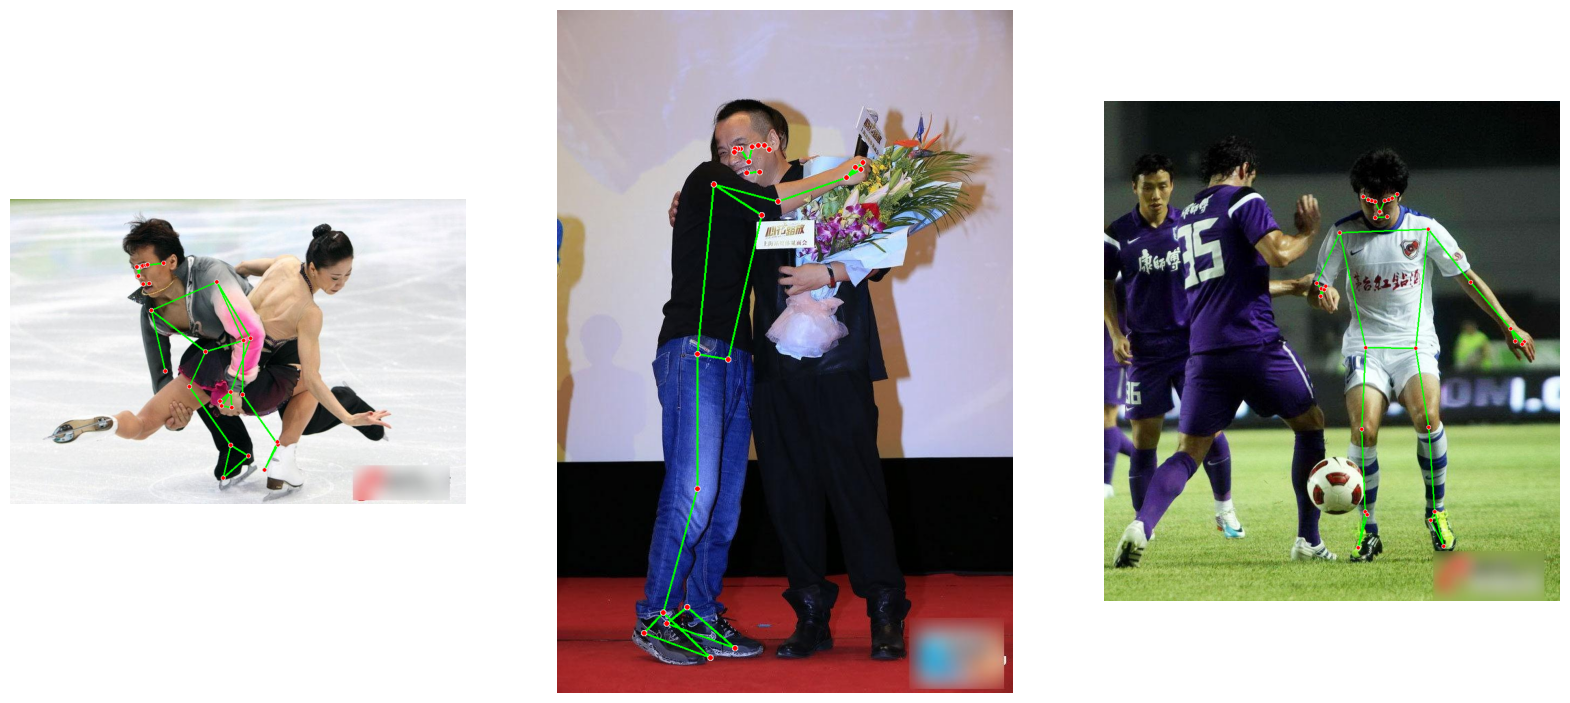

In [39]:
image_sample = os.path.join(images_data_root_dir, '005000.jpg')
image_sample1 = os.path.join(images_data_root_dir, '001250.jpg')
image_sample2 = os.path.join(images_data_root_dir, '003236.jpg')
def process_images(image_samples):
    images = []
    for path in image_samples:
        annotated_image, _ = estimate_pose(path)
        images.append(annotated_image)
    return images

image_samples = [image_sample, image_sample1, image_sample2]
annotated_images = process_images(image_samples)

# Plot the pose estimation on sample images
plt.figure(figsize=(20, 10))
for i, img in enumerate(annotated_images):
    plt.subplot(1, len(annotated_images), i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()